# First glance and etc

In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from IPython.display import HTML
import math
from PIL import Image
import dlib
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0')

## Data

#### Constants

In [3]:
IMG_WHT = 160
IMG_HHT = 160
ETA = 1e-2

# Layers


In [4]:
def weigth_initialization(conv_weigths, init):
    if (init == 'xavier_normal'):
        nn.init.xavier_normal_(conv_weigths)
    if (init == 'xavier_uniform'):
        nn.init.xavier_uniform_(conv_weigths)
    return
        

def conv(input_channels, 
         output_channels,
         kernel_size, stride, 
         padding, weigth_init = 'xavier_normal', 
         batch_norm = False,
         activation=nn.ReLU()):
    a = []
    a.append(nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding))
    weigth_initialization(a[-1].weight, weigth_init)
    if activation is not None:
        a.append(activation)
    if batch_norm:
        a.append(nn.BatchNorm2d(output_channels))
    return nn.Sequential(*a)

def deconv(input_channels, 
         output_channels,
         kernel_size, stride, 
         padding, weigth_init = 'xavier_normal', 
         batch_norm = False,
         activation=nn.ReLU()):
    a = []
    a.append(nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding))
    weigth_initialization(a[-1].weight, weigth_init)
    if activation is not None:
        a.append(activation)
    if batch_norm:
        a.append(nn.BatchNorm2d(output_channels))
    return nn.Sequential(*a)


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels,
                output_channels = None, 
                kernel_size = 3, stride = 1, 
                padding = None, weight_init = 'xavier_normal', 
                batch_norm = False,
                activation=nn.ReLU()):
        super(ResidualBlock, self).__init__()
        self.activation = activation
        if output_channels is None:
            output_channels = input_channels // stride
        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.conv(input_channels, output_channels, 1, stride, 0, None, False, None)
            
        a = []
        a.append( conv( input_channels , input_channels  , kernel_size , 1 , padding if padding is not None else (kernel_size - 1)//2 , weight_init ,  False, activation))
        a.append( conv( input_channels , output_channels , kernel_size , 1 , padding if padding is not None else (kernel_size - 1)//2 , None , False, None))
        self.model = nn.Sequential(*a)
        
    def forward(self, x):
        return self.activation(self.model(x) + self.shortcut(x))
    

# Formula to calculate padding (for me)

output_size: $$O = \Big[\frac{W−F+2P}{S}\Big]+1$$ where W - input_size, F - filter size, P - padding, S - stride $$$$
Therefore, $$P = \frac{S \cdot (O - 1) + F - W}{2} $$


In [6]:

def calc_conv_outsize(input_size, filter_size, stride, pad):
    return math.floor((input_size - filter_size + 2 * pad) / stride) + 1

In [7]:
def round_half_up(n):
    return math.floor(n + 0.5)

In [8]:
def calc_conv_pad(input_size, output_size, filter_size, stride):
    return round_half_up((stride * (output_size - 1) + filter_size - input_size) / 2)

def calc_deconv_pad(input_size, output_size, filter_size, stride):
    return round_half_up((stride * (input_size - 1) + filter_size - output_size) / 2)

## Generator

In [9]:
def same_padding(size, kernel_size, stride, dilation):
    return ((size - 1) * (stride - 1) + dilation * (kernel_size - 1)) // 2

In [124]:
def show_feature_map(c):
    s = int(c.size()[1] / 4)
    fig, ax = plt.subplots(s, 4, figsize=(15, 10))
    for i in range(s):
        for j in range(4):
            ax[i, j].imshow(c[0][j*s + i].cpu().detach())
    
def show(tensor):
    img = transforms.ToPILImage()(tensor)
    plt.imshow(img)
    plt.show()

In [99]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        ##ENCODER##

        
        f = np.array([64, 64, 128, 256, 512]) / 2
        
        f = f.astype(int)

        
        batch_norm = True
        self.conv0 = nn.Sequential(conv(9, f[0], 7, 1, calc_conv_pad(IMG_WHT, IMG_WHT, 7, 1), "xavier_normal", batch_norm, nn.ReLU(ETA)), # 128 x 128
                                   ResidualBlock(f[0], activation = nn.ReLU(ETA))) 
        self.conv1 = nn.Sequential(conv(f[0], f[1], 5, 2, calc_conv_pad(IMG_WHT, IMG_WHT / 2, 5, 2), "xavier_normal",  batch_norm, nn.ReLU(ETA)), # 64 x 64
                                   ResidualBlock(f[1], activation = nn.ReLU(ETA)))
        self.conv2 = nn.Sequential(conv(f[1], f[2], 3, 2, calc_conv_pad(IMG_WHT / 2, IMG_WHT / 4, 3, 2), "xavier_normal", batch_norm, nn.ReLU(ETA)),  # 32 x 32
                                   ResidualBlock(f[2], activation = nn.ReLU(ETA))) 
        self.conv3 = nn.Sequential(conv(f[2], f[3], 3, 2, calc_conv_pad(IMG_WHT / 4, IMG_WHT / 8, 3, 2), "xavier_normal",  batch_norm, nn.ReLU(ETA)), # 16 x 16
                                   ResidualBlock(f[3], activation = nn.ReLU(ETA))) 
        self.conv4 = nn.Sequential(conv(f[3], f[4], 3, 2, calc_conv_pad(IMG_WHT / 8, IMG_WHT / 16, 3, 2), "xavier_normal", batch_norm, nn.ReLU(ETA)), # 8 x 8
                                   ResidualBlock(f[4], activation = nn.ReLU(ETA))) 
      
        self.fc1 = nn.Linear(f[4] * 10 * 10, f[4])
        self.relu = nn.ReLU(inplace=True)
        self.maxout = nn.MaxPool1d(2 )
        ##DECODER##
        
        self.fc2 = nn.Linear(f[3], f[1] * 10 * 10) 
        
        #first path - 3 deconvs
        
        
        f = np.array([64, 32, 16, 8]) / 2
        f = f.astype(int)

        
        self.dc0_1 = deconv(f[0], f[1], 4, 4, calc_deconv_pad(IMG_WHT / 16, IMG_WHT / 4, 4, 4), "xavier_normal", batch_norm, activation=nn.ReLU(ETA)) # 32 x 32
        self.dc0_2 = deconv(f[1], f[2], 2, 2, calc_deconv_pad(IMG_WHT / 4, IMG_WHT / 2, 2, 2), "xavier_normal", batch_norm, activation=nn.ReLU(ETA)) # 64 x 64
        self.dc0_3 = deconv(f[2], f[3], 2, 2, calc_deconv_pad(IMG_WHT / 2, IMG_WHT, 2, 2), "xavier_normal", batch_norm, activation=nn.ReLU(ETA)) # 128 x 128
        
        #u-net path - 4 deconvs

        
        f = np.array([512, 256, 128, 64, 32, 16, 8]) / 2
        f = f.astype(int)

        
        self.dc1 = nn.Sequential(deconv(f[0] + f[3], f[0], 2, 2, calc_deconv_pad(IMG_WHT / 16, IMG_WHT / 8, 2, 2),"xavier_normal", batch_norm, activation=nn.ReLU(ETA)), # 16 x 16
                                 ResidualBlock(f[0], activation = nn.ReLU(ETA)),
                                 ResidualBlock(f[0], activation = nn.ReLU(ETA)))
        self.dc2 = nn.Sequential(deconv(f[0] + f[1], f[1], 2, 2, calc_deconv_pad(IMG_WHT / 8, IMG_WHT / 4, 2, 2),"xavier_normal", batch_norm, activation=nn.ReLU(ETA)), # 32 x 32
                                 ResidualBlock(f[1], activation = nn.ReLU(ETA)),
                                 ResidualBlock(f[1], activation = nn.ReLU(ETA)))
        self.dc3 = nn.Sequential(deconv(f[2] + f[1] + 3 + f[4], f[2], 2, 2, calc_deconv_pad(IMG_WHT / 4, IMG_WHT / 2, 2, 2), "xavier_normal", batch_norm, activation=nn.ReLU(ETA)), # 64 x 64
                                 ResidualBlock(f[2], activation = nn.ReLU(ETA)),
                                 ResidualBlock(f[2], activation = nn.ReLU(ETA)))
        self.dc4 = nn.Sequential(deconv(f[2] + f[3] + 3 + f[5], f[3], 2, 2, calc_deconv_pad(IMG_WHT / 2, IMG_WHT, 2, 2), "xavier_normal", batch_norm, activation=nn.ReLU(ETA)), # 128 x 128
                                 ResidualBlock(f[3], activation = nn.ReLU(ETA)),
                                 ResidualBlock(f[3], activation = nn.ReLU(ETA)))

        #final convs
        
        self.conv5 = conv(f[1], 3, 3, 1, calc_conv_pad(IMG_WHT / 4, IMG_WHT / 4, 3, 1), "xavier_normal", batch_norm, nn.ReLU(ETA)) # 32 x 32
        self.conv6 = conv(f[2], 3, 3, 1, calc_conv_pad(IMG_WHT / 2, IMG_WHT / 2, 3, 1), "xavier_normal", batch_norm, nn.ReLU(ETA)) # 64 x 64
        self.conv7 = conv(f[3] + f[3] + 3 + f[6], f[3], 5, 1, calc_conv_pad(IMG_WHT, IMG_WHT, 5, 1), "xavier_normal", batch_norm, nn.ReLU(ETA)) # 128 x 128
        self.conv8 = conv(f[3], f[4], 3, 1, calc_conv_pad(IMG_WHT, IMG_WHT, 3, 1), "xavier_normal", batch_norm, nn.ReLU(ETA)) # 128 x 128
        self.conv9 = conv(f[4], 3, 3, 1, calc_conv_pad(IMG_WHT, IMG_WHT, 3, 1), "xavier_normal", batch_norm, nn.ReLU(ETA)) # 128 x 128
        
    def forward(self, picture, landmarks_real, landmarks_wanted): #img = x
        #Ecoder
        x = torch.cat([picture, landmarks_real, landmarks_wanted], dim = 1)
        c0 = self.conv0(x)
        c1 = self.conv1(c0)

        c2 = self.conv2(c1)

        c3 = self.conv3(c2)

        c4 = self.conv4(c3)
    
        tmp = self.num_flat_features(c4)
        f1 = c4.view(x.size()[0], tmp)
        f1 = self.fc1(f1)
        f1 = self.relu(f1)
        f1 = f1.unsqueeze(0)
        maxout = self.maxout(f1)[0]
        
        #Decoder
        #1
        
        f2 = self.fc2(maxout)
        rsh = f2.reshape((x.size()[0], int(64 / 2), 10, 10))
        
        dc01 = self.dc0_1(rsh)
        
        dc02 = self.dc0_2(dc01)
        dc03 = self.dc0_3(dc02)
        
        #2
        dc1r = self.dc1(torch.cat((rsh, c4), dim=1))
        dc2r = self.dc2(torch.cat((dc1r, c3), dim=1))
        pic_div_2 = nn.MaxPool2d(2)(picture)
        pic_div_4 = nn.MaxPool2d(2)(pic_div_2)
        dc3r = self.dc3(torch.cat((dc2r, c2, pic_div_4, dc01), dim=1))
        dc4r = self.dc4(torch.cat((dc3r, c1, pic_div_2, dc02), dim=1))
        #3
        
        c5 = self.conv5(dc2r)
        c6 = self.conv6(dc3r)
    
        c7 = self.conv7(torch.cat((dc4r, c0, picture, dc03), dim=1))
        show_feature_map(c7)
        c8 = self.conv8(c7)
        show_feature_map(c8)
        c9 = self.conv9(c8)
   
        
        return c5, c6, c9  #img_32, img_64, img_128
        #return picture, nn.MaxPool2d(2)(picture), nn.MaxPool2d(2)(nn.MaxPool2d(2)(picture))
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [100]:
from modelsummary import summary

In [104]:
#summary(Generator(), torch.zeros((1, 3, 160, 160)), torch.zeros((1, 3, 160, 160)), torch.zeros(1, 3, 160, 160))

## Disciminator

In [105]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        batch_norm = True
        self.model = nn.Sequential(conv(6, 64, 4, 2, calc_conv_pad(IMG_WHT, IMG_WHT / 2, 4, 2), "xavier_normal", batch_norm, nn.ReLU(ETA)), # 64 x 64
                                   conv(64, 128, 4, 2, calc_conv_pad(IMG_WHT / 2, IMG_WHT / 4, 4, 2), "xavier_normal", batch_norm, nn.ReLU(ETA)), # 32 x 32
                                       conv(128, 256, 4, 2, calc_conv_pad(IMG_WHT / 4, IMG_WHT / 8, 4, 2), "xavier_normal", batch_norm, nn.ReLU(ETA)), # 16 x 16
                                   conv(256, 512, 4, 2, calc_conv_pad(IMG_WHT / 8, IMG_WHT / 16, 4, 2), "xavier_normal", batch_norm, nn.ReLU(ETA)), # 8 x 8
                                   conv(512, 512, 4, 1, calc_conv_pad(IMG_WHT / 16, 7, 4, 1), "xavier_normal", batch_norm, nn.ReLU(ETA)), # 7 x 7
                                   conv(512, 1, 4, 1, calc_conv_pad(7, 6, 4, 1), "xavier_normal", batch_norm, nn.Sigmoid())) # 6 x 6
    def forward(self, x, y):
        x = torch.cat([x, y], dim = 1)
        return nn.Softmax(dim=3)(self.model(x))
    

In [106]:
d = Discriminator()

In [107]:
d( torch.zeros((1, 3, 160, 160)),  torch.zeros((1, 3, 160, 160)))

tensor([[[[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]]]],
       grad_fn=<SoftmaxBackward>)

# Data

In [108]:
multipie_path = r'multi_PIE_crop_128/001/001_01_01_051_00_crop_128.png'

In [109]:
import shutil
import os

### НЕ ЗАПУСКАТЬ, ЕСЛИ  папки img_list и frontal_faces УЖЕ ЕСТЬ

In [110]:
# MAIN_DIR = 'multi_PIE_crop_128'
# subdirs = [x[0] for x in os.walk(MAIN_DIR)][1:]
# for subdir in subdirs:
#     for f in os.listdir(subdir):
#         if (os.path.isfile(os.path.join(subdir, f))):
#             tmp = f.split('.')[0].split('_')
#             path = '\\'.join([subdir, f])
#             if (tmp[3] == '051' and tmp[4] == '07' and tmp[6] == '128'):
#                 with Image.open(path) as img:
#                     img.thumbnail((40, 40),Image.ANTIALIAS)
#                     path_40 = '\\'.join(['frontal_faces', f.split('.')[0][:-3] + '40.png'])
#                     img.save(path_40, 'PNG', quality=80)
#                 with Image.open(path) as img:
#                     img.thumbnail((80, 80),Image.ANTIALIAS)
#                     path_80 = '\\'.join(['frontal_faces', f.split('.')[0][:-3] + '80.png'])
#                     img.save(path_80, 'PNG', quality=80)
#                 with Image.open(path) as img:
#                     img = img.resize((160, 160),Image.ANTIALIAS)
#                     path_160 = '\\'.join(['frontal_faces', f.split('.')[0][:-3] + '160.png'])
#                     img.save(path_160, 'PNG', quality=80)
#             elif (f.split('.')[0].split('_')[4] == '07' and tmp[6] == '128'):
#                     with Image.open(path) as img:
#                         img = img.resize((160, 160),Image.ANTIALIAS)
#                         path_160 = '\\'.join(['img_list', f.split('.')[0][:-3] + '160.png'])
#                         img.save(path_160, 'PNG', quality=80)

### Train data generator

In [111]:
import cv2
from imutils import face_utils
from torch.utils.data import Dataset

In [112]:
# ПОДГОТОВИЛИ DLIB
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
LAND_MARKS_INDEXES = [37, 40, 43, 46, 34, 49, 67, 55]

In [113]:
IMG_LIST_PATH = 'img_list'
FRONTAL_FACES_PATH = 'frontal_faces'

In [114]:
def get_landmarks(link):
        img = cv2.imread(link)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # The square where we place landmarks
        black = cv2.imread("black_square160.png")
        rects = detector(gray, 0)
        for rect in rects:
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            for (i, (x, y)) in enumerate(shape):
                if ((i + 1) in LAND_MARKS_INDEXES):
                    cv2.circle(black, (x, y), 2, (0, 255, 0), -1)
        return transforms.ToTensor()(Image.fromarray(black))


class TrainDataset( Dataset):
    def __init__( self , img_list ):
        super(type(self),self).__init__()
        self.img_list = img_list
    def __len__( self ):
        return len(self.img_list)
    def __getitem__( self , idx ):
        #example - 001_01_01_010_05_crop_128
        batch = {}
        img_name = self.img_list[idx]
        img_frontal_name = '_'.join(img_name.split('_')[:3]) + '_051_07_crop_'
        with Image.open('/'.join([IMG_LIST_PATH, img_name])) as img:
            batch['img'] = transforms.ToTensor()(img)
        with Image.open( '/'.join([FRONTAL_FACES_PATH, img_frontal_name + '160.png'])) as img:
            batch['img160_wanted'] = transforms.ToTensor()(img)
        with Image.open( '/'.join([FRONTAL_FACES_PATH, img_frontal_name + '40.png'])) as img:
            batch['img40_wanted'] = transforms.ToTensor()(img)
        with Image.open( '/'.join([FRONTAL_FACES_PATH, img_frontal_name + '80.png'])) as img:
            batch['img80_wanted'] = transforms.ToTensor()(img)
        # GET LANDMARKS

        batch['landmarks_real'] = get_landmarks('/'.join([IMG_LIST_PATH, img_name]))
        batch['landmarks_wanted'] = get_landmarks('/'.join([FRONTAL_FACES_PATH, img_frontal_name + '160.png']))
        
        return batch

### Составим img_list из фоток с поворотом не больше чем на +- 60 градусов

In [115]:
img_list = []
for f in os.listdir(IMG_LIST_PATH):
    tmp = f.split('.')[0].split('_')
    angle = int(tmp[3])
    if ((angle > 30 and angle <= 80) or (angle >= 130 and angle <= 180)):
        img_list.append(f)
        

##### Small dataset for checking 

In [116]:
# img_list = img_list[0:200]

##### Shuffle and divide into train and test

In [117]:
random_seed = 42
val_split = 0.15

In [118]:
indices = list(range(0, len(img_list)))
split = int(np.floor(val_split * len(img_list)))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [119]:
train_img_list = list(np.array(img_list)[train_indices])
test_img_list = list(np.array(img_list)[val_indices])

In [120]:
train = TrainDataset(train_img_list)
test = TrainDataset(test_img_list)

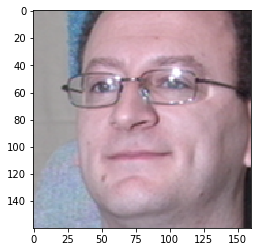

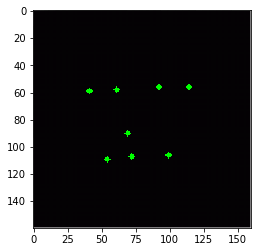

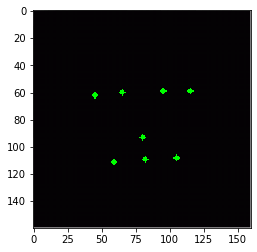

In [127]:
show(train[0]['img'])
show(train[0]['landmarks_real'])
show(train[0]['landmarks_wanted'])

In [128]:
train_dataloader = torch.utils.data.DataLoader( train , batch_size = 4 , shuffle = True) 
test_dataloader = torch.utils.data.DataLoader( test , batch_size = 4 , shuffle = True) 

# Feature extractor 


In [129]:
from keras.models import load_model
from PIL import Image
import torchvision.transforms.functional as ttf

In [130]:
from facenet_pytorch import InceptionResnetV1

# Loss

In [131]:
def set_requires_grad(module , b ):
    for parm in module.parameters():
        parm.requires_grad = b

In [132]:
N_EPOCHS = 10

## Tensorboard

In [133]:
from torch.utils.tensorboard import SummaryWriter

# LEARNING

In [134]:
def save_model(model,model_name, dirname,epoch):
    if type(model).__name__ == torch.nn.DataParallel.__name__:
        model = model.module
    torch.save( model.state_dict() , '{}/{}_epoch{}.pth'.format(dirname,type(model).__name__ + '_' + model_name,epoch ) )
    
def save_optimizer(optimizer,model, model_name, dirname,epoch):
    if type(model).__name__ ==  torch.nn.DataParallel.__name__:
        model = model.module
    torch.save( optimizer.state_dict() , '{}/{}_epoch_{}.pth'.format(dirname,type(optimizer).__name__ +'_' +type(model).__name__ + '_' + model_name,epoch ) )

def resume_model(model,model_name, path ,i, strict= True):
    if type(model).__name__ == torch.nn.DataParallel.__name__:
        model = model.module
    p = "{}/{}_epoch{}.pth".format( path,type(model).__name__+ '_' + model_name,i )
    print(p)
    if os.path.exists( p ):
        model.load_state_dict(  torch.load( p ) , strict = strict)
        return i
    else:
        raise NameError("No model saved file with this epoch")
def resume_model_old(model, path ,i, strict= True):
    if type(model).__name__ == torch.nn.DataParallel.__name__:
        model = model.module
    p = "{}/{}_epoch{}.pth".format( path,type(model).__name__,i )
    print(p)
    if os.path.exists( p ):
        model.load_state_dict(  torch.load( p ) , strict = strict)
        return i
    else:
        raise NameError("No model saved file with this epoch")

In [135]:
LAST_EPOCH = 0

RESUME_MODEL = False

LEARNING_RATE = 0.0002

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device) # предобученная нейросеть
for param in resnet.parameters():
        param.requires_grad = False
        
G = nn.DataParallel(Generator()).to(device)
D1 = nn.DataParallel(Discriminator()).to(device) # Этот дискриминатор отличает изображение (img) и то, как генератор его повернул 
D2 = nn.DataParallel(Discriminator()).to(device) # Этот дискриминатор отличает повернутое G изображение и landmarks_wanted 

if RESUME_MODEL:
    resume_model(G, "G", "models_save", LAST_EPOCH)
    resume_model(D1, "D1", "models_save", LAST_EPOCH)
    resume_model(D2, "D2", "models_save", LAST_EPOCH)

optimizer_G = torch.optim.Adam(G.parameters(), lr = LEARNING_RATE)
optimizer_D1 = torch.optim.Adam(D1.parameters(), lr = LEARNING_RATE) 
optimizer_D2 = torch.optim.Adam(D2.parameters(), lr = LEARNING_RATE) 

L1 = torch.nn.L1Loss().to(device)

mse = torch.nn.MSELoss().to(device)

cross_entropy = torch.nn.CrossEntropyLoss().to(device)

tb = SummaryWriter()  
epoch = LAST_EPOCH
while(True):
    print("## EPOCH", epoch,"##")
    for step, batch in enumerate(train_dataloader):
        for k in  batch:
            batch[k] =  torch.autograd.Variable( batch[k].to(device) , requires_grad = False) 
        # adversarial loss
        if (step % 100 == 0):
            print(step)
            
        img_40_fake, img_80_fake, img_160_fake = G(batch['img'], batch['landmarks_real'], batch['landmarks_wanted'])

        set_requires_grad( D1 , True )
        L_D1 = 0.1 *(torch.mean( - torch.log( D1(batch['img160_wanted'], batch['img'])) - torch.log( 1 -  D1(img_160_fake.detach(), batch['img']))))
        optimizer_D1.zero_grad()
        L_D1.backward()
        optimizer_D1.step()
        set_requires_grad( D1 , False )
        
        set_requires_grad( D2 , True )
        L_D2 = 0.1*(torch.mean( - torch.log( D2(batch['img160_wanted'], batch['landmarks_wanted'])) - torch.log( 1 -  D2(img_160_fake.detach(), batch['landmarks_wanted']))))
        optimizer_D2.zero_grad()
        L_D2.backward()
        optimizer_D2.step()
        set_requires_grad( D2 , False )
        
        pixelwise_160_loss = L1(img_160_fake, batch['img160_wanted'])
        pixelwise_80_loss = L1(img_80_fake, batch['img80_wanted'])
        pixelwise_40_loss = L1(img_40_fake, batch['img40_wanted'])
        features_real = resnet(batch['img160_wanted'])
        features_fake = resnet(img_160_fake)
        
        features_real80 = resnet(batch['img80_wanted'])
        features_fake80 = resnet(img_80_fake)

        identity_loss = mse(features_real.detach(), features_fake)
        #identity_loss80 = mse(features_real80.detach(), features_fake80)
        
        total_variation = torch.mean( torch.abs(  img_160_fake[:,:,:-1,:] - img_160_fake[:,:,1:,:] ) )  + torch.mean(  torch.abs( img_160_fake[:,:,:,:-1] - img_160_fake[:,:,:,1:] ) )
        #total_variation80 = torch.mean( torch.abs(  img_80_fake[:,:,:-1,:] - img_80_fake[:,:,1:,:] ) )  + torch.mean(  torch.abs( img_80_fake[:,:,:,:-1] - img_80_fake[:,:,:,1:] ) )  
        
        L_final = 10 * pixelwise_160_loss + 0.1 * pixelwise_80_loss + (1e-4)*pixelwise_40_loss + 0.02 * (identity_loss) + (total_variation)
        optimizer_G.zero_grad()
        L_final.backward()
        optimizer_G.step()
      
        tb.add_scalar( "D1_loss/Train" , L_D1.data.cpu().numpy() ,  epoch*len(train_dataloader) + step)
        tb.add_scalar( "D2_loss/Train" , L_D2.data.cpu().numpy() ,  epoch*len(train_dataloader) + step)
        tb.add_scalar( "pixelwise_160_los/Train" , pixelwise_160_loss.data.cpu().numpy() ,   epoch*len(train_dataloader) + step)
        tb.add_scalar( "pixelwise_80_los/Train" , pixelwise_80_loss.data.cpu().numpy() ,   epoch*len(train_dataloader) + step)
        tb.add_scalar( "pixelwise_40_los/Train" , pixelwise_40_loss.data.cpu().numpy() ,   epoch*len(train_dataloader) + step)
        tb.add_scalar( "identity_loss/Train" , identity_loss.data.cpu().numpy() ,  epoch*len(train_dataloader) + step)
        tb.add_scalar( "total_variation_loss/Train" , total_variation.data.cpu().numpy() ,  epoch*len(train_dataloader) + step)
        tb.add_scalar( "final_loss/Train" , L_final.data.cpu().numpy() , epoch*len(train_dataloader) + step )
   
            
    if (epoch % 20 == 0):
        save_model(G, "G","D:models_saving",  epoch)
        save_model(D1,"D1",  "D:models_saving", epoch)
        save_model(D2,  "D2", "D:models_saving", epoch)
        save_optimizer(optimizer_G,G, "G", "D:optimizer_saving",epoch)
        save_optimizer(optimizer_D1,D1, "D1",  "D:optimizer_saving",epoch)
        save_optimizer(optimizer_D2,D2, "D2", "D:optimizer_saving",epoch)
    
    print("VALIDATION")
    img_batch = np.zeros((4, 3, 160, 160))
    img_batch_index = 0
    identity_mse = 0
    for step, batch in enumerate(test_dataloader):
        for k in  batch:
            batch[k] =  torch.autograd.Variable( batch[k].to(device) , requires_grad = False)
            
        img_40_fake, img_80_fake, img_160_fake = G(batch['img'], batch['landmarks_real'], batch['landmarks_wanted'])
        features_real = resnet(batch['img160_wanted'])
        features_fake = resnet(img_160_fake)

        identity_mse += mse(features_real.detach(), features_fake.clone().detach())
        
        if step % 30 == 0 :
            print(step)
            img_batch[img_batch_index % 4] = img_160_fake[0].cpu().clone().detach()
            img_batch_index += 1
    tb.add_scalar("identity_mse/Test" , identity_mse.data.cpu().numpy() / len(test_dataloader),  epoch)
    
    if (epoch % 10 == 0):
        tb.add_images("img_160_fake/Validation", img_batch, epoch)
    LAST_EPOCH = epoch
    epoch += 1

## EPOCH 0 ##
0


c:\users\artem\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


# TEST

D:models_no_variation/Generator_G_epoch40.pth


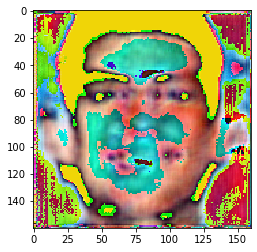

In [64]:
RESUME_EPOCH = 40
G = nn.DataParallel(Generator()).to(device)
resume_model(G, "G", "D:models_no_variation", RESUME_EPOCH)
idx = 0
img_40_fake, img_80_fake, img_160_fake = G(test[idx]['img'].unsqueeze(0), test[idx]['landmarks_real'].unsqueeze(0), test[idx]['landmarks_wanted'].unsqueeze(0))
show(img_160_fake.cpu()[0])

D:models_saving_python/Generator_G_epoch1225.pth


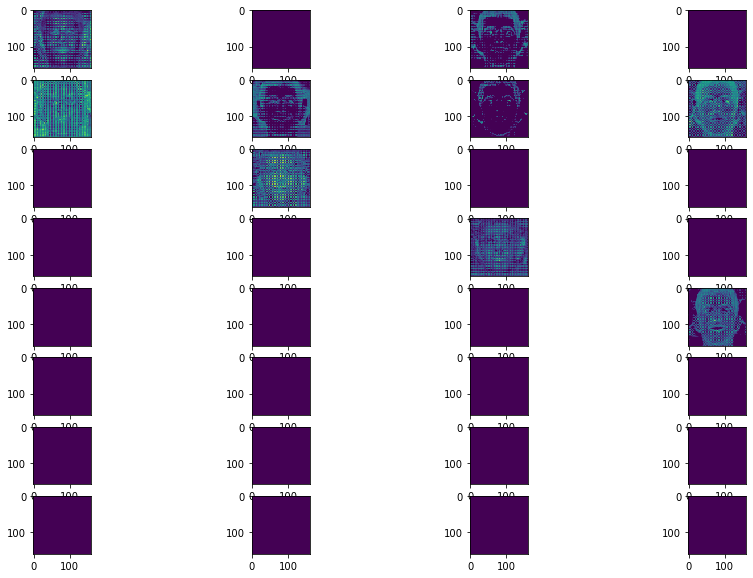

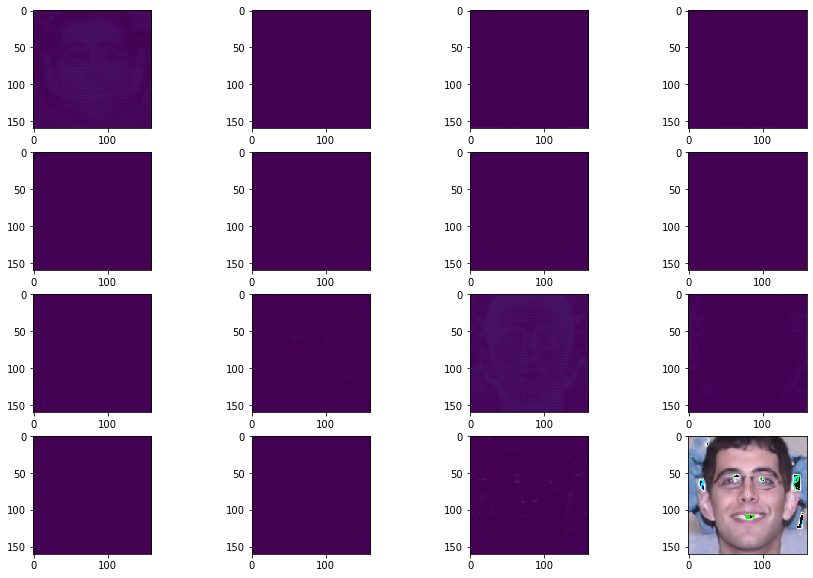

In [95]:
RESUME_EPOCH = 1225
G = nn.DataParallel(Generator()).to(device)
resume_model(G, "G", "D:models_saving_python", RESUME_EPOCH)
idx = 0
img_40_fake, img_80_fake, img_160_fake = G(test[idx]['img'].unsqueeze(0), test[idx]['landmarks_real'].unsqueeze(0), test[idx]['landmarks_wanted'].unsqueeze(0))
show(img_160_fake.cpu()[0])

In [61]:
idx = 50
img_40_fake, img_80_fake, img_160_fake = G(test[idx]['img'].unsqueeze(0), test[idx]['landmarks_real'].unsqueeze(0), test[idx]['landmarks_wanted'].unsqueeze(0))

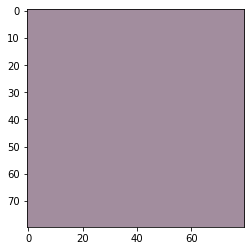

In [97]:
show(img_80_fake.cpu()[0])

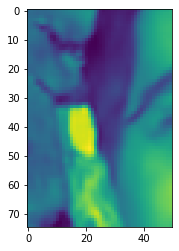

In [186]:
plt.imshow(img_160_fake.cpu()[0][0][25:100, 0:50].detach())

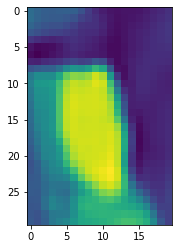

In [187]:
plt.imshow(img_160_fake.cpu()[0][0][50:80, 10:30].detach())

### Когда умер TOTAL_VARIATION?


D:models_saving_python/Generator_G_epoch35.pth


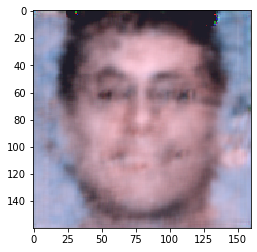

In [193]:
RESUME_EPOCH = 35
G = nn.DataParallel(Generator()).to(device)
resume_model(G, "G", "D:models_saving_python", RESUME_EPOCH)
idx = 0
img_40_fake, img_80_fake, img_160_fake = G(test[idx]['img'].unsqueeze(0), test[idx]['landmarks_real'].unsqueeze(0), test[idx]['landmarks_wanted'].unsqueeze(0))
show(img_160_fake.cpu()[0])

D:models_saving_python/Generator_G_epoch70.pth


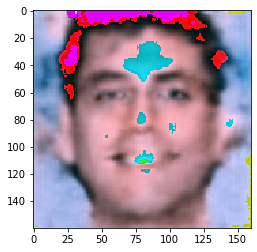

In [198]:
RESUME_EPOCH = 70
G = nn.DataParallel(Generator()).to(device)
resume_model(G, "G", "D:models_saving_python", RESUME_EPOCH)
idx = 0
img_40_fake, img_80_fake, img_160_fake = G(test[idx]['img'].unsqueeze(0), test[idx]['landmarks_real'].unsqueeze(0), test[idx]['landmarks_wanted'].unsqueeze(0))
show(img_160_fake.cpu()[0])

D:models_saving_python/Generator_G_epoch1225.pth


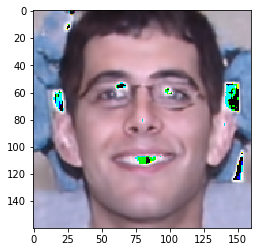

In [200]:
RESUME_EPOCH = 1225
G = nn.DataParallel(Generator()).to(device)
resume_model(G, "G", "D:models_saving_python", RESUME_EPOCH)
idx = 0
img_40_fake, img_80_fake, img_160_fake = G(test[idx]['img'].unsqueeze(0), test[idx]['landmarks_real'].unsqueeze(0), test[idx]['landmarks_wanted'].unsqueeze(0))
show(img_160_fake.cpu()[0])

In [86]:
a = torch.tensor(np.array([[[1, 2, 3], [4, -5, 6]], [[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]]]))
a = a.unsqueeze(0)

In [87]:
torch.abs(a[:,:,:-1,:] - a[:,:,1:,:])

tensor([[[[3, 7, 3]],

         [[3, 3, 3]],

         [[3, 3, 3]]]], dtype=torch.int32)

In [83]:
a[:,:,1:,:]

tensor([[[[4, 5, 6]],

         [[4, 5, 6]],

         [[4, 5, 6]]]], dtype=torch.int32)